Set the matplotlib magic to notebook enable inline plots

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Calculate the Nonredundant Read Fraction (NRF)

SAM format example:
```
SRR585264.8766235       0       1       4       15      35M     *       0       0       CTTAAACAATTATTCCCCCTGCAAACATTTTCAAT     GGGGGGGGGGGGGGGGGGGGGGFGGGGGGGGGGGG    XT:A:U   NM:i:1  X0:i:1  X1:i:6  XM:i:1  XO:i:0  XG:i:0  MD:Z:8T26
```

Import the required modules

In [2]:
import subprocess
import matplotlib.pyplot as plt
import random
import numpy as np

Make figures prettier and biger

In [3]:
plt.style.use('ggplot')
figsize(10,5)

##### Parse the SAM file and extract the unique start coordinates.

First store the file name in the variable

In [4]:
file = "./bwa/input2.sorted.bam"

Next we read the file using samtools. From each read we need to store the flag, chromosome name and start coordinate.

In [5]:
p = subprocess.Popen(["samtools", "view", "-q10", "-F260", file],
                      stdout=subprocess.PIPE)
coords = []
for line in p.stdout:
    flag, ref, start = line.decode('utf-8').split()[1:4]
    coords.append([flag, ref, start])

In [36]:
coords[:3]

[[u'16', u'20', u'194'], [u'16', u'20', u'211'], [u'16', u'20', u'479']]

What is the total number of our unique reads?

In [6]:
len(coords)

1459281

Randomly sample the coordinates to get 1M for NRF calculations

In [7]:
random.seed(1234)
sample = random.sample(coords, 1000000)

In [8]:
len(sample)

1000000

How many of those coordinates are **unique**? (We will use the *set* python object which only the unique items.)

In [9]:
uniqueStarts = {'watson': set(), 'crick': set()}
for coord in sample:
    flag, ref, start = coord
    if int(flag) & 16:
        uniqueStarts['crick'].add((ref, start))
    else:
        uniqueStarts['watson'].add((ref, start))

How many on the Watson strand?

In [10]:
len(uniqueStarts['watson'])

462589

And on the Crick?

In [11]:
len(uniqueStarts['crick'])

451756

Calculate the **NRF**

In [12]:
NRF_input = (len(uniqueStarts['watson']) + len(uniqueStarts['crick']))*1.0/len(sample)
print(NRF_input)

0.914345


Lets create a function from what we did above and apply it to all of our files!

To use our function on the real sequencing datasets (not only on a small subset) we need to optimize our method a bit- we will use python module called numpy.

In [13]:
def calculateNRF(filePath, pickSample=True, sampleSize=10000000, seed=1234):
    p = subprocess.Popen(['samtools', 'view', '-q10', '-F260', filePath],
                          stdout=subprocess.PIPE)
    coordType = np.dtype({'names': ['flag', 'ref', 'start'],
                          'formats': ['uint16', 'U10', 'uint32']})
    coordArray = np.empty(10000000, dtype=coordType)
    i = 0
    for line in p.stdout:
        if i >= len(coordArray):
            coordArray = np.append(coordArray, np.empty(1000000, dtype=coordType), axis=0)
        fg, rf, st = line.decode('utf-8').split()[1:4]
        coordArray[i] = np.array((fg, rf, st), dtype=coordType)
        i += 1
    coordArray = coordArray[:i]
    sample = coordArray
    if pickSample and len(coordArray) > sampleSize:
        np.random.seed(seed)
        sample = np.random.choice(coordArray, sampleSize, replace=False)
    uniqueStarts = {'watson': set(), 'crick': set()}
    for read in sample:
        flag, ref, start = read
        if flag & 16:
            uniqueStarts['crick'].add((ref, start))
        else:
            uniqueStarts['watson'].add((ref, start))
    NRF = (len(uniqueStarts['watson']) + len(uniqueStarts['crick']))*1.0/len(sample)
    return NRF

Calculate the NRF for the chip-seq sample

In [14]:
NRF_chip = calculateNRF("./bwa/sox2_chip.sorted.bam", sampleSize=1000000)
print(NRF_chip)

0.836835


Plot the NRF!

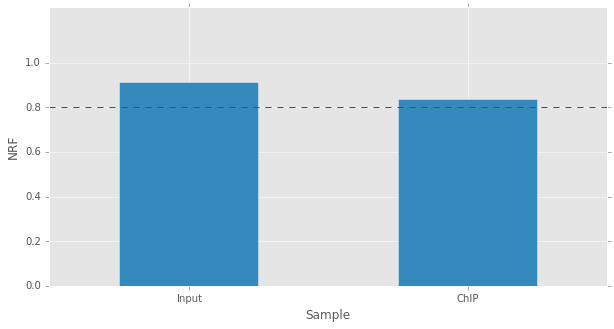

In [15]:
plt.bar([0,2],[NRF_input, NRF_chip], width=1)
plt.xlim([-0.5,3.5]), plt.xticks([0.5, 2.5], ['Input', 'ChIP'])
plt.xlabel('Sample')
plt.ylabel('NRF')
plt.ylim([0, 1.25]), plt.yticks(np.arange(0, 1.2, 0.2))
plt.plot((-0.5,3.5), (0.8,0.8), 'red', linestyle='dashed')
plt.show()

### Calculate the Signal Extraction Scaling

Load the results from the coverage calculations

In [17]:
countList = []
with open('./bedtools/input_coverage.bed', 'r') as covFile:
    for line in covFile:
        countList.append(int(line.strip('\n').split('\t')[3]))
countList[0:6]

[6, 15, 13, 19, 1, 6]

In [18]:
countList[-15:]

[26, 42, 21, 21, 9, 16, 16, 28, 25, 19, 13, 4, 18, 36, 20]

Lets see where do our reads align to the genome. Plot the distribution of tags along the genome.

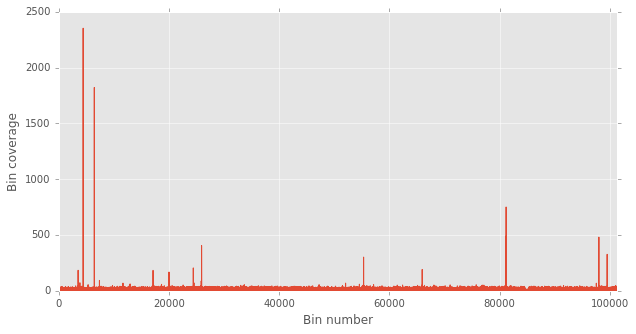

In [19]:
plt.plot(range(len(countList)), countList)
plt.xlabel('Bin number')
plt.ylabel('Bin coverage')
plt.xlim([0, len(countList)])
plt.show()

Now sort the list- order the windows based on the tag count

In [20]:
countList.sort()

In [21]:
countList[0:6]

[0, 0, 0, 0, 0, 0]

Sum all the aligned tags

In [22]:
countSum = sum(countList)
countSum

1563897

Calculate the summaric fraction of tags along the ordered windows.

In [ ]:
countFraction = []
for i, count in enumerate(countList):
    if i == 0:
        countFraction.append(count*1.0 / countSum)
    else:
        countFraction.append((count*1.0 / countSum) + countFraction[i-1])

Look at the last five items of the list:

In [42]:
countFraction[-5:]

[0.9965374957558283,
 0.9968501761945017,
 0.9973303868477608,
 0.9984954252102616,
 1.0000000000000335]

Calculate the number of windows.

In [24]:
winNumber = len(countFraction)
winNumber

101267

Calculate what fraction of a whole is the position of each window.

In [40]:
winFraction = []
for i in range(winNumber):
    winFraction.append(i*1.0 / winNumber)

Look at the last five items of our new list:

In [41]:
winFraction[-5:]

[0.9999506255739777,
 0.9999605004591822,
 0.9999703753443866,
 0.999980250229591,
 0.9999901251147956]

Now prepare the function!

In [26]:
def calculateSES(filePath):
    countList = []
    with open(filePath, 'r') as covFile:
        for line in covFile:
            countList.append(int(line.strip('\n').split('\t')[3]))
    plt.plot(range(len(countList)), countList)
    plt.xlabel('Bin number')
    plt.ylabel('Bin coverage')
    plt.xlim([0, len(countList)])
    plt.show()
    countList.sort()
    countSum = sum(countList)
    countFraction = []
    for i, count in enumerate(countList):
        if i == 0:
            countFraction.append(count*1.0 / countSum)
        else:
            countFraction.append((count*1.0 / countSum) + countFraction[i-1])
    winNumber = len(countFraction)
    winFraction = []
    for i in range(winNumber):
        winFraction.append(i*1.0 / winNumber)
    return [winFraction, countFraction]

Use our function to calculate the signal extraction scaling for the Sox2 ChIP sample:

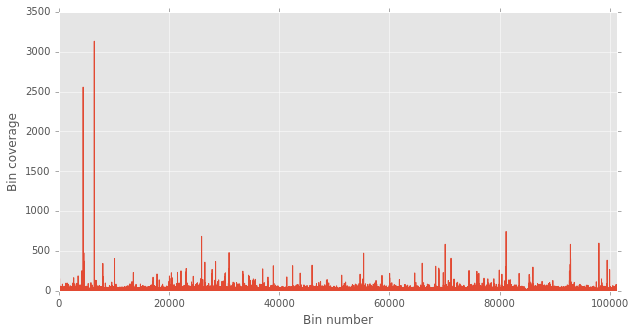

In [27]:
chipSes = calculateSES("./bedtools/sox2_chip_coverage.bed")

Now we can plot the calculated fractions for both the input and ChIP sample:

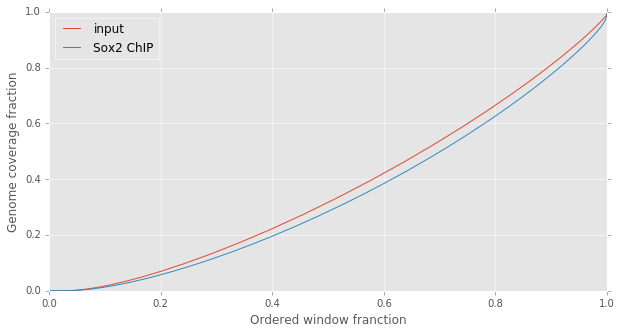

In [39]:
plt.plot(winFraction, countFraction, label='input')
plt.plot(chipSes[0], chipSes[1], label='Sox2 ChIP')
plt.ylim([0,1])
plt.xlabel('Ordered window franction')
plt.ylabel('Genome coverage fraction')
plt.legend(loc='best')
plt.show()